### segment waveform into individual syllables using dynamic thresholding
- 

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
import pandas as pd
from datetime import datetime

In [20]:
import warnings
warnings.filterwarnings(action='once')

In [21]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [22]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [23]:
DATASET_ID = 'canary'

### Load data in original format

In [24]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2019-10-07_12-10-47'

### create dataset

In [25]:
hparams = HParams(
    n_fft = 4096,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -100,
    win_length_ms = 4,
    hop_length_ms = 1,
    n_jobs = -1,
    verbosity=1,
    nex = -1
)

In [26]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/avgn/utils/json.py:64: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/canary/2019-10-07_12-03-35/JSON/bird3_0139_2004_03_10_07_33.JSON' mode='r' encoding='UTF-8'>
  return json.load(open(json_loc), object_pairs_hook=OrderedDict)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 1122 tasks      | elapsed:   54.0s


[Parallel(n_jobs=-1)]: Done 2555 out of 2555 | elapsed:   56.7s finished


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:5605: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/AD/tsainbur/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/ops/signal/util_ops.py:62: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  return ops.convert_to_tensor(fractions.gcd(const_a, const_b))


In [27]:
dataset.sample_json

OrderedDict([('indvs',
              OrderedDict([('bird3',
                            OrderedDict([('phrases',
                                          OrderedDict([('start_times',
                                                        [0.0,
                                                         2.572916666666667,
                                                         4.086875,
                                                         5.70375,
                                                         7.2231250000000005,
                                                         8.013958333333333,
                                                         9.4575,
                                                         11.0175,
                                                         11.700000000000001,
                                                         12.672291666666666,
                                                         17.300833333333333]),
                            

### segment and plot 
- for each json, load the wav file - segment the file into start and end times
- plot the segmentation
- add to the JSON 

In [35]:
from avgn.utils.audio import load_wav
from avgn.signalprocessing.filtering import butter_bandpass_filter
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

In [36]:
from vocalseg.dynamic_thresholding import plot_segmented_spec, plot_segmentations

In [37]:
import joblib

In [63]:
### segmentation parameters
n_fft=4096
hop_length_ms=1
win_length_ms=4
ref_level_db=20
pre=0.97
min_level_db=-100
min_level_db_floor = -60
db_delta = 5
silence_threshold = 0.01
min_silence_for_spec=0.05
max_vocal_for_spec=1.0,
min_syllable_length_s = 0.01
butter_min = 500
butter_max = 20000
spectral_range = [500, 20000]

In [64]:
from avgn.utils.json import NoIndent, NoIndentEncoder

In [65]:
warnings.filterwarnings("ignore", message = "'tqdm_notebook' object has no attribute 'sp'")
def segment_spec_custom(key, df, save=False, plot=False):
    # load wav
    rate, data = load_wav(df.data["wav_loc"])
    # filter data
    data = butter_bandpass_filter(data, butter_min, butter_max, rate)

    # segment
    results = dynamic_threshold_segmentation(
        data,
        rate,
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        min_silence_for_spec=min_silence_for_spec,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=True,
        min_syllable_length_s=min_syllable_length_s,
        spectral_range=spectral_range,
    )
    if results is None:
        print('skipping')
        return
    if plot:
        plot_segmentations(
            results["spec"],
            results["vocal_envelope"],
            results["onsets"],
            results["offsets"],
            hop_length_ms,
            rate,
        )
        plt.show()

    # save the results
    json_out = DATA_DIR / "processed" / (DATASET_ID + "_segmented") / DT_ID / "JSON" / (
        key + ".JSON"
    )

    json_dict = df.data.copy()

    json_dict["indvs"][list(df.data["indvs"].keys())[0]]["syllables"] = {
        "start_times": NoIndent(list(results["onsets"])),
        "end_times": NoIndent(list(results["offsets"])),
    }

    json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)
    # save json
    if save:
        ensure_dir(json_out.as_posix())
        print(json_txt, file=open(json_out.as_posix(), "w"))

    #print(json_txt)

    return results

In [66]:
indvs = np.array(['_'.join(list(i)) for i in dataset.json_indv])
np.unique(indvs)

array(['bird1', 'bird2', 'bird3', 'bird4', 'bird6'], dtype='<U5')

In [67]:
pd.DataFrame({indv:[np.sum(indvs == indv)] for indv in np.unique(indvs)})

bird1  bird2  bird3  bird4  bird6
0    330    277    566    675    707

bird1


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


/mnt/cube/tsainbur/Projects/github_repos/vocalization_segmentation/vocalseg/dynamic_thresholding.py:129: RuntimeWarning: invalid value encountered in sqrt
  vocal_envelope = np.max(spec, axis=0) * np.sqrt(np.mean(spec, axis=0))


longest silence 0.10200000000000031
longest vocalization 0.24400000000000066


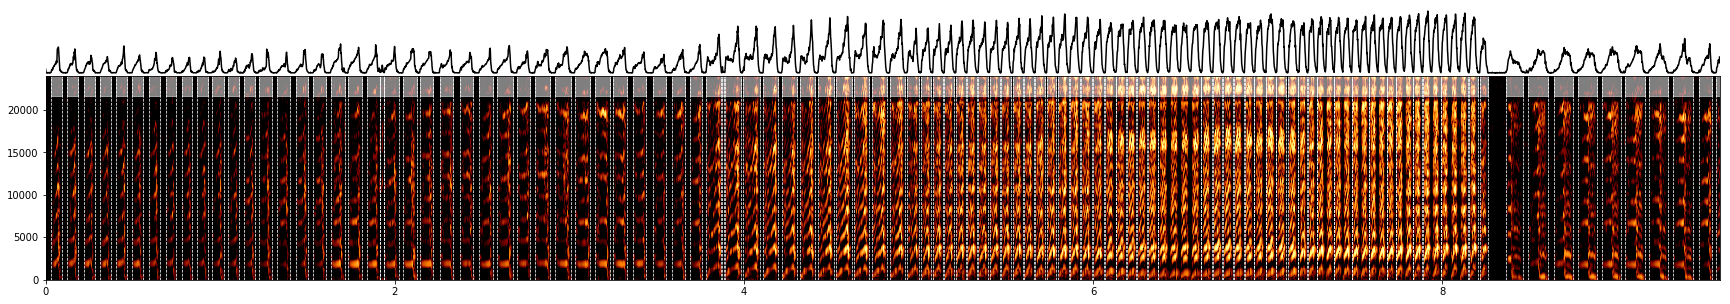

longest silence 0.07099999999999973
longest vocalization 0.35199999999999854


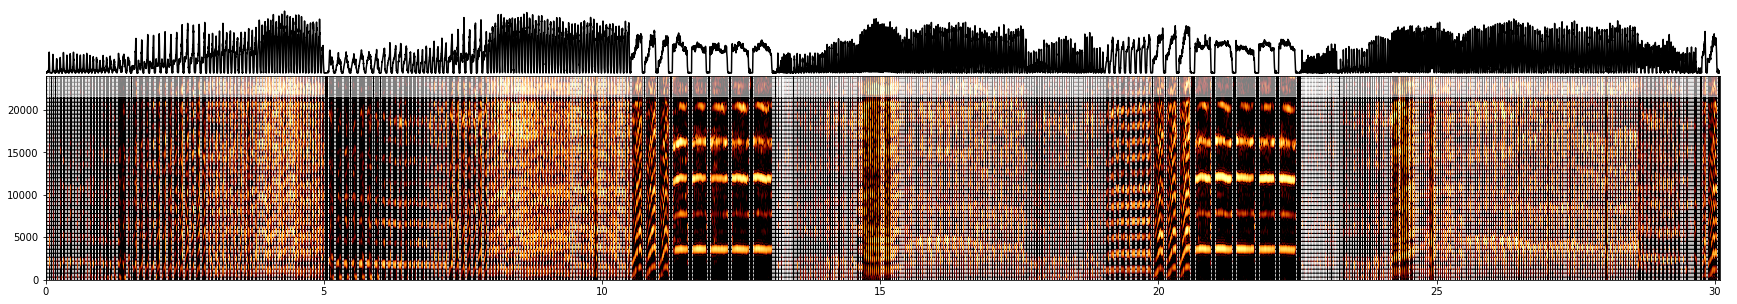

longest silence 0.10200000000000031
longest vocalization 0.35999999999999943


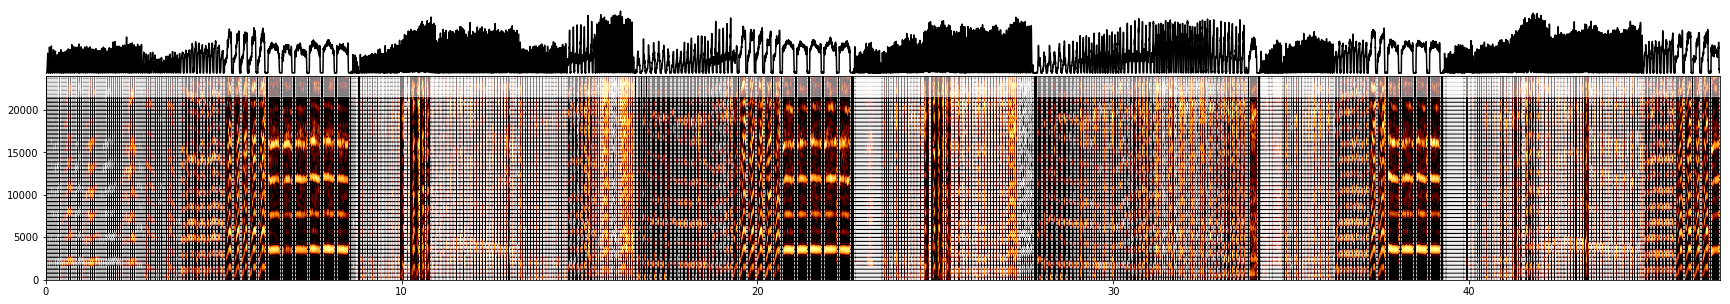

bird2


longest silence 0.002000000000000224
longest vocalization 0.9820000000000002
Current min_level_db: -100
longest silence 0.002000000000000224
longest vocalization 0.9820000000000002
Current min_level_db: -95
longest silence 0.002000000000000224
longest vocalization 0.9820000000000002
Current min_level_db: -90
longest silence 0.002000000000000224
longest vocalization 0.9820000000000002
Current min_level_db: -85
longest silence 0.0040000000000000036
longest vocalization 0.4889999999999999
Current min_level_db: -80
longest silence 0.01599999999999957
longest vocalization 0.43100000000000094
Current min_level_db: -75
longest silence 0.04300000000000015
longest vocalization 0.4139999999999997
Current min_level_db: -70
longest silence 0.05999999999999872
longest vocalization 0.3990000000000009


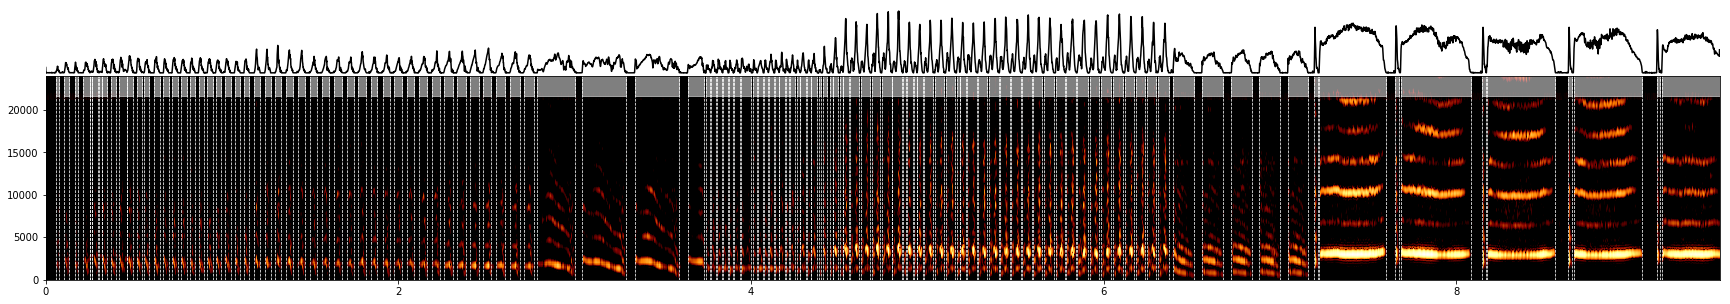

longest silence 0.0050000000000000044
longest vocalization 0.5919999999999996
Current min_level_db: -100
longest silence 0.0050000000000000044
longest vocalization 0.5919999999999996
Current min_level_db: -95
longest silence 0.0050000000000000044
longest vocalization 0.5919999999999996
Current min_level_db: -90
longest silence 0.0050000000000000044
longest vocalization 0.5339999999999998
Current min_level_db: -85
longest silence 0.014999999999999902
longest vocalization 0.4540000000000006
Current min_level_db: -80
longest silence 0.014999999999999902
longest vocalization 0.45199999999999996
Current min_level_db: -75
longest silence 0.03699999999999992
longest vocalization 0.4480000000000004
Current min_level_db: -70
longest silence 0.052000000000000046
longest vocalization 0.4480000000000004


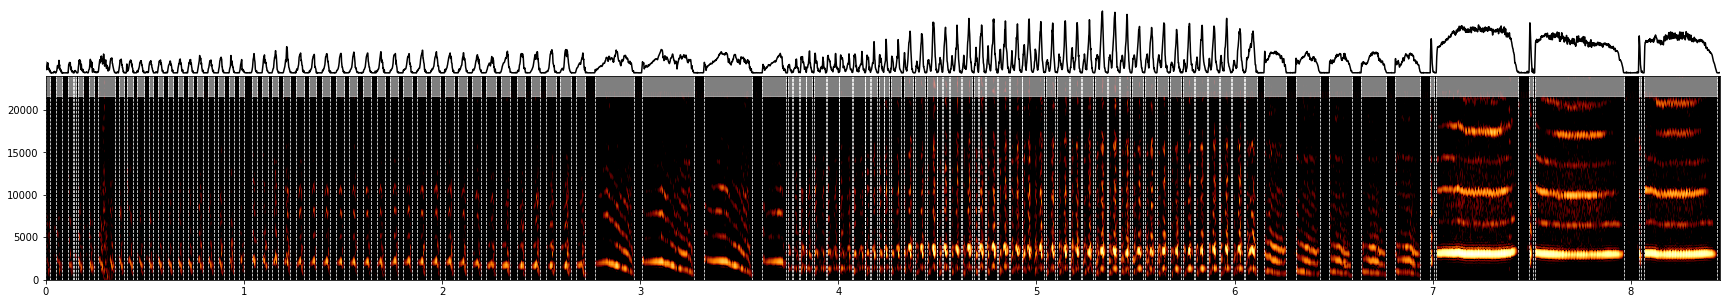

longest silence 0.0039999999999995595
longest vocalization 1.3249999999999993
Current min_level_db: -100
longest silence 0.0039999999999995595
longest vocalization 1.3249999999999993
Current min_level_db: -95
longest silence 0.0039999999999995595
longest vocalization 1.3249999999999993
Current min_level_db: -90
longest silence 0.004999999999999893
longest vocalization 0.9299999999999997
Current min_level_db: -85
longest silence 0.01100000000000012
longest vocalization 0.4670000000000005
Current min_level_db: -80
longest silence 0.05500000000000016
longest vocalization 0.44200000000000017


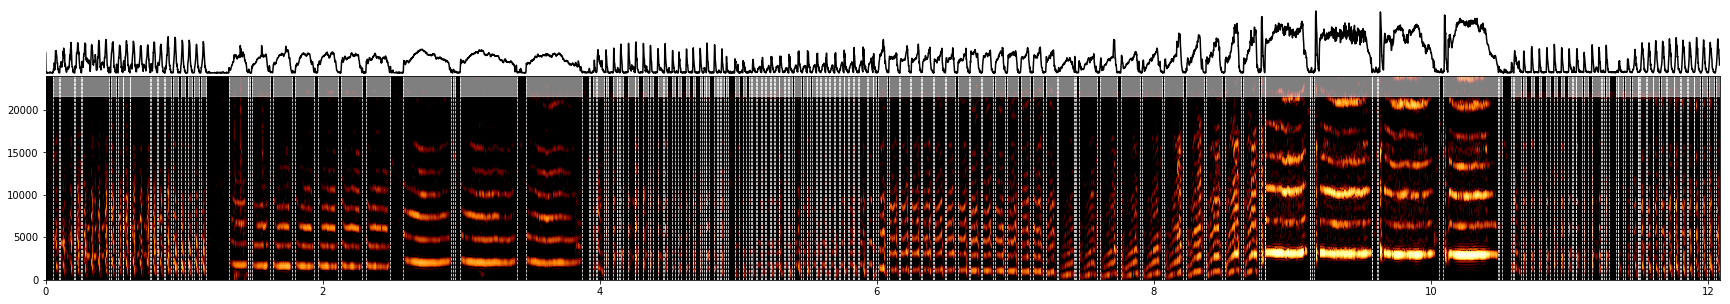

bird3


longest silence 0.021999999999999797
longest vocalization 0.5129999999999999
Current min_level_db: -100
longest silence 0.03299999999999992
longest vocalization 0.5129999999999999
Current min_level_db: -95
longest silence 0.03299999999999992
longest vocalization 0.4670000000000005
Current min_level_db: -90
longest silence 0.050000000000000266
longest vocalization 0.4169999999999998


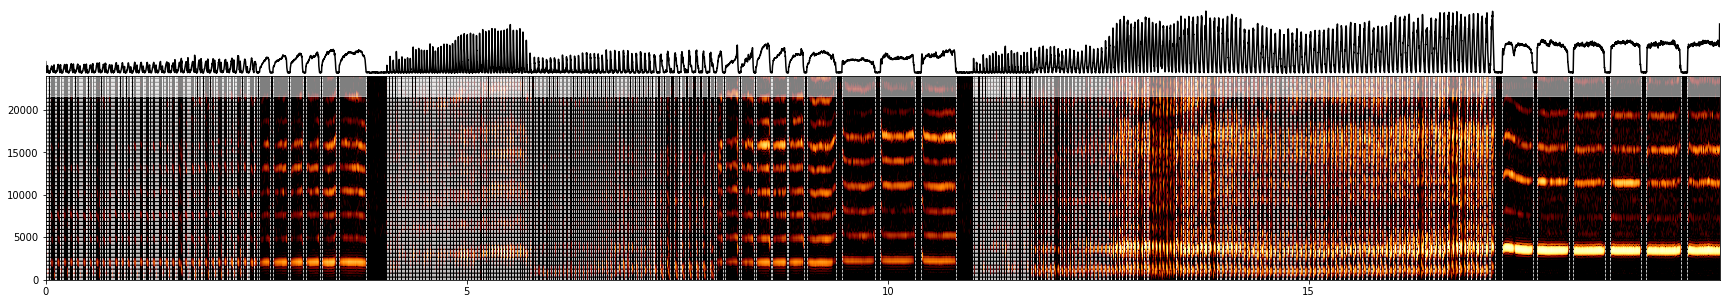

longest silence 0.02200000000000024
longest vocalization 0.40300000000000047
Current min_level_db: -100
longest silence 0.02200000000000024
longest vocalization 0.40300000000000047
Current min_level_db: -95
longest silence 0.027000000000000135
longest vocalization 0.40300000000000047
Current min_level_db: -90
longest silence 0.07299999999999951
longest vocalization 0.40199999999999925


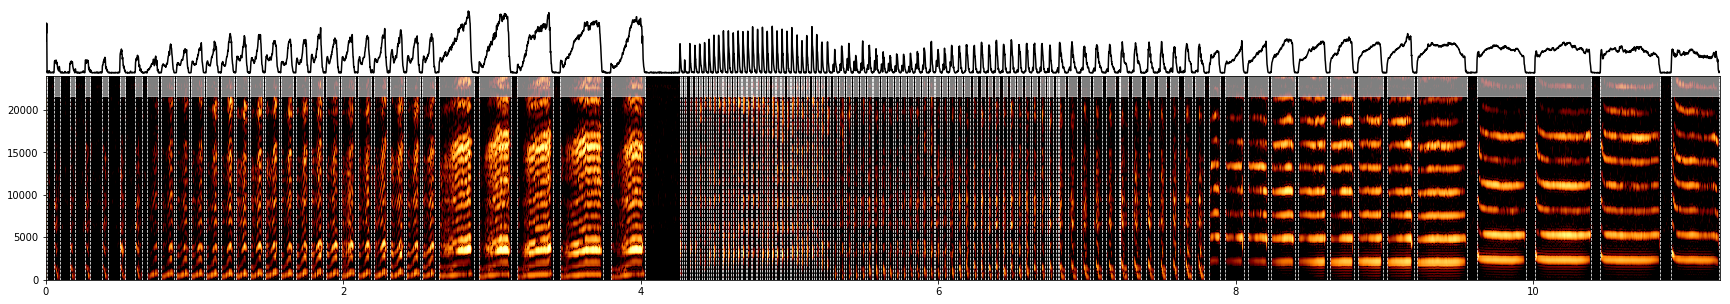

longest silence 0.15700000000000003
longest vocalization 0.36900000000000155


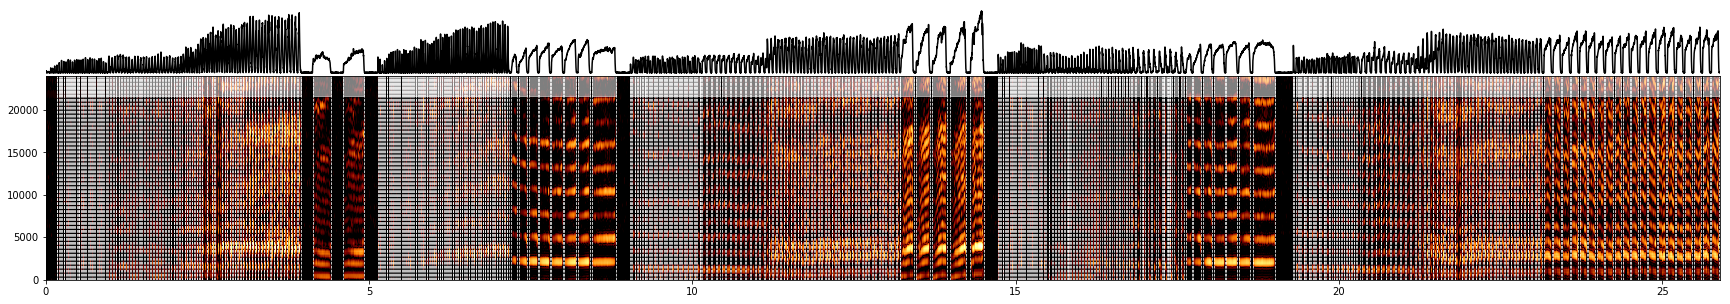

bird4


longest silence 0.032
longest vocalization 0.4350000000000023
Current min_level_db: -100
longest silence 0.032
longest vocalization 0.4350000000000023
Current min_level_db: -95
longest silence 0.032
longest vocalization 0.4350000000000023
Current min_level_db: -90
longest silence 0.06599999999999895
longest vocalization 0.4350000000000023


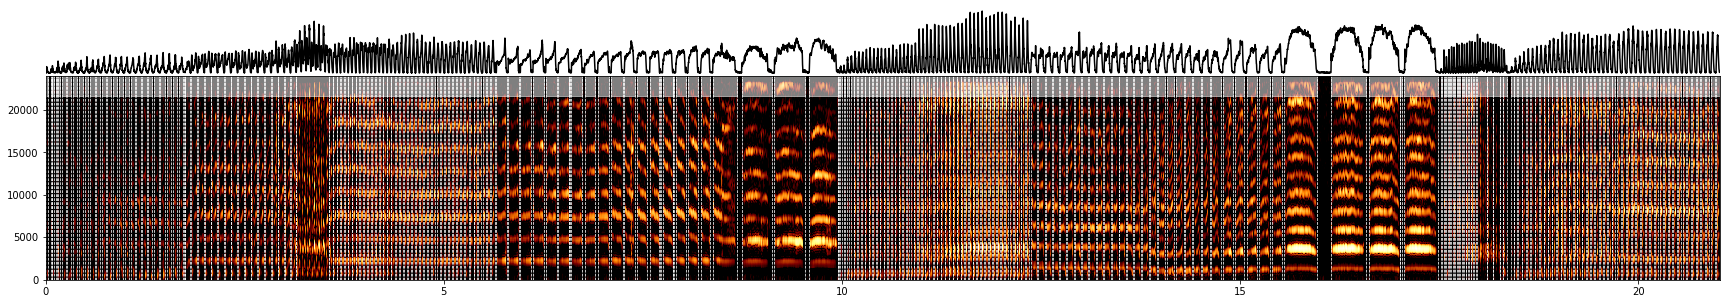

longest silence 0.022999999999999687
longest vocalization 0.42900000000000205
Current min_level_db: -100
longest silence 0.022999999999999687
longest vocalization 0.42900000000000205
Current min_level_db: -95
longest silence 0.022999999999999687
longest vocalization 0.42900000000000205
Current min_level_db: -90
longest silence 0.022999999999999687
longest vocalization 0.42900000000000205
Current min_level_db: -85
longest silence 0.049000000000001265
longest vocalization 0.39299999999999713
Current min_level_db: -80
longest silence 0.0649999999999995
longest vocalization 0.3819999999999979


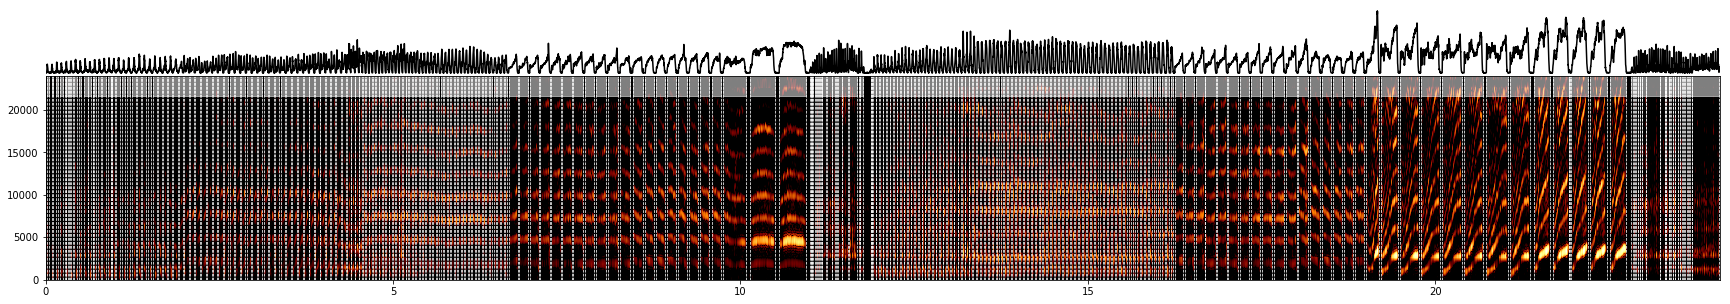

longest silence 0.017999999999998906
longest vocalization 0.726
Current min_level_db: -100
longest silence 0.017999999999998906
longest vocalization 0.726
Current min_level_db: -95
longest silence 0.017999999999998906
longest vocalization 0.726
Current min_level_db: -90
longest silence 0.030000000000001137
longest vocalization 0.6019999999999999
Current min_level_db: -85
longest silence 0.06400000000000006
longest vocalization 0.601


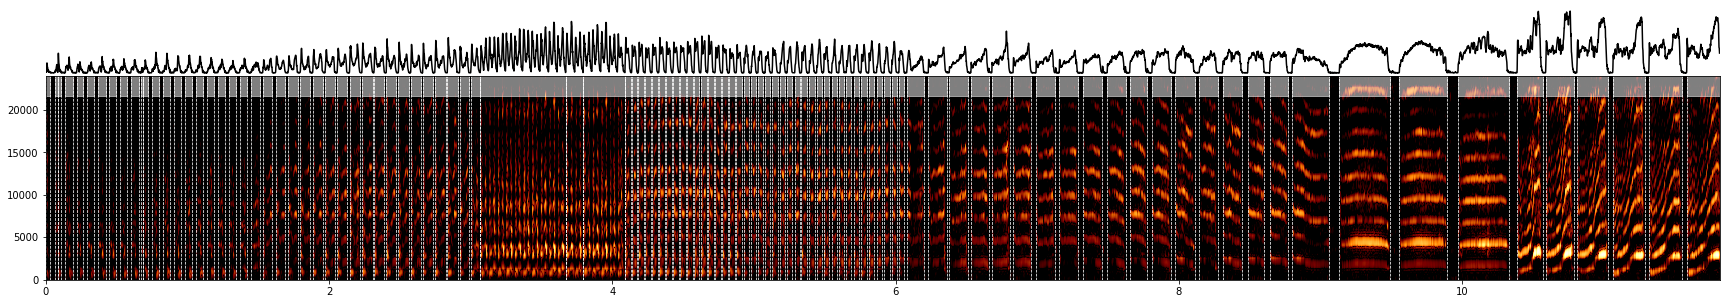

bird6


longest silence 0.08000000000000002
longest vocalization 0.5419999999999994


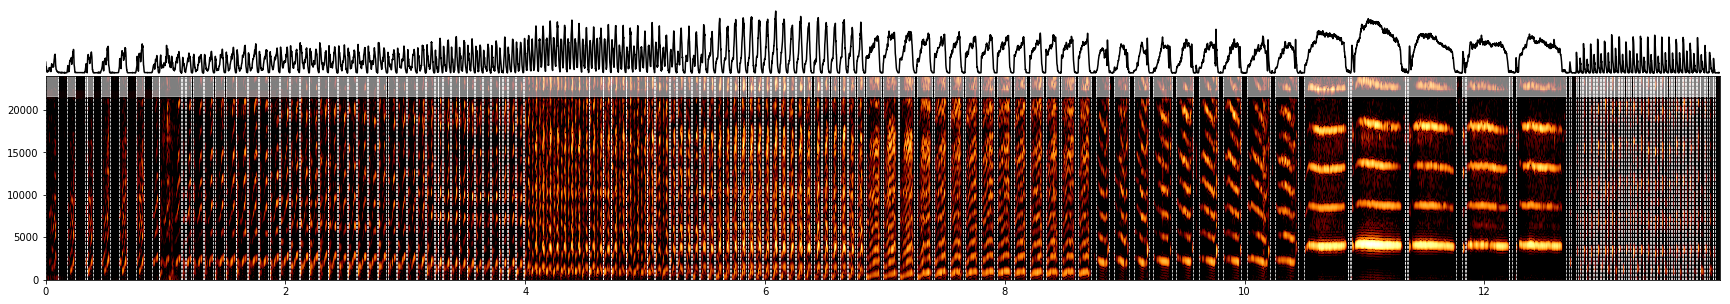

longest silence 0.031000000000000028
longest vocalization 0.3259999999999996
Current min_level_db: -100
longest silence 0.031000000000000028
longest vocalization 0.3259999999999996
Current min_level_db: -95
longest silence 0.031000000000000028
longest vocalization 0.3259999999999996
Current min_level_db: -90
longest silence 0.05700000000000005
longest vocalization 0.24399999999999977


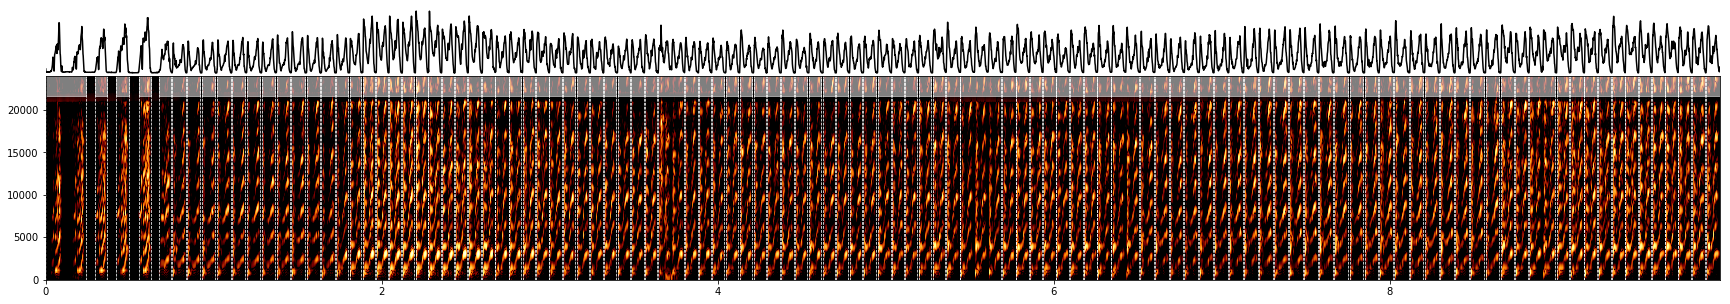

longest silence 0.04200000000000004
longest vocalization 0.16400000000000148
Current min_level_db: -100
longest silence 0.04200000000000004
longest vocalization 0.16400000000000148
Current min_level_db: -95
longest silence 0.05399999999999994
longest vocalization 0.16300000000000026


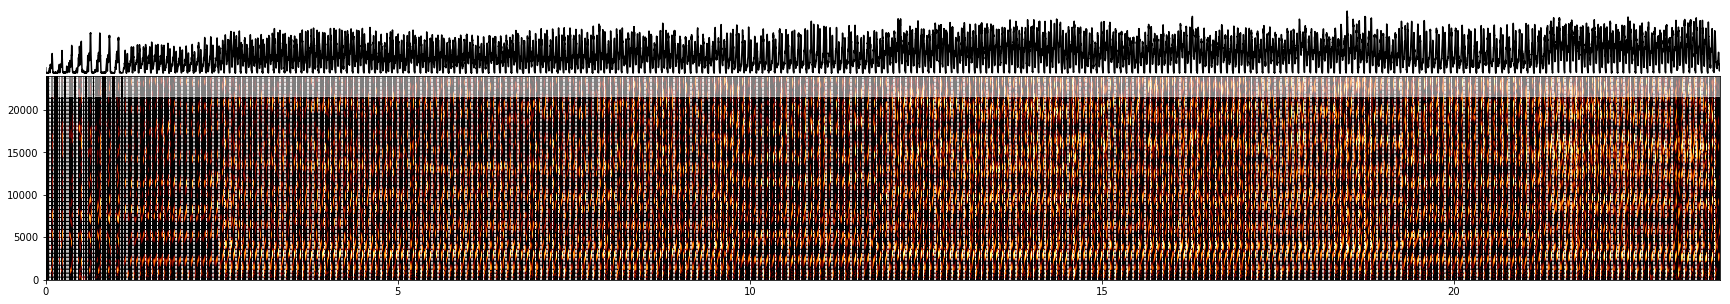

In [68]:
nex = 3
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]

    joblib.Parallel(n_jobs=1, verbose=0)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], plot=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

### Generate for full dataset

In [69]:
nex = -1
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]

    joblib.Parallel(n_jobs=10, verbose=11)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], save=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

bird1


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   13.7s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:   24.9s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:   28.0s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:   29.3s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   30.7s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:   32.4s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:   33.6s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:   35.1s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:   37.2s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:   42.4s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:   44.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   45.4s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:   46.6s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:   53.3s
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=10)]: Done 132 tasks      | elapsed:  4.4min
[Parallel(n_jobs=10)]: Done 133 tasks      | elapsed:  4.4min
[Parallel(n_jobs=10)]: Done 134 tasks      | elapsed:  4.4min
[Parallel(n_jobs=10)]: Done 135 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 137 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 138 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 139 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 141 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 143 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 144 tasks      | elapsed:  4.5min
[Parallel(n_jobs=10)]: Done 145 tasks      | elapsed:  4.6min
[Parallel(n_jobs=10)]: Done 146 tasks      | elapsed:  4.6min
[Parallel(n_jobs=10)]: Done 147 tasks      | elapsed:  4.7min
[Paralle

[Parallel(n_jobs=10)]: Done 265 tasks      | elapsed: 10.2min
[Parallel(n_jobs=10)]: Done 266 tasks      | elapsed: 10.2min
[Parallel(n_jobs=10)]: Done 267 tasks      | elapsed: 10.3min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed: 10.3min
[Parallel(n_jobs=10)]: Done 269 tasks      | elapsed: 10.4min
[Parallel(n_jobs=10)]: Done 270 tasks      | elapsed: 10.4min
[Parallel(n_jobs=10)]: Done 271 tasks      | elapsed: 10.5min
[Parallel(n_jobs=10)]: Done 272 tasks      | elapsed: 10.5min
[Parallel(n_jobs=10)]: Done 273 tasks      | elapsed: 10.6min
[Parallel(n_jobs=10)]: Done 274 tasks      | elapsed: 10.6min
[Parallel(n_jobs=10)]: Done 275 tasks      | elapsed: 10.7min
[Parallel(n_jobs=10)]: Done 276 tasks      | elapsed: 10.7min
[Parallel(n_jobs=10)]: Done 277 tasks      | elapsed: 10.8min
[Parallel(n_jobs=10)]: Done 278 tasks      | elapsed: 10.8min
[Parallel(n_jobs=10)]: Done 279 tasks      | elapsed: 10.9min
[Parallel(n_jobs=10)]: Done 280 tasks      | elapsed: 10.9min
[Paralle

bird2


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:   17.2s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:   17.9s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:   18.6s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:   19.5s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   20.3s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:   22.2s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:   23.3s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:   24.1s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:   33.7s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:   35.1s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:   37.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   38.1s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:   38.1s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:   39.4s
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=10)]: Done 197 tasks      | elapsed:  5.8min
[Parallel(n_jobs=10)]: Done 198 tasks      | elapsed:  5.8min
[Parallel(n_jobs=10)]: Done 199 tasks      | elapsed:  5.8min
[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed:  5.9min
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:  5.9min
[Parallel(n_jobs=10)]: Done 202 tasks      | elapsed:  5.9min
[Parallel(n_jobs=10)]: Done 203 tasks      | elapsed:  6.0min
[Parallel(n_jobs=10)]: Done 204 tasks      | elapsed:  6.0min
[Parallel(n_jobs=10)]: Done 205 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done 206 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done 207 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done 208 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done 209 tasks      | elapsed:  6.1min
[Parallel(n_jobs=10)]: Done 210 tasks      | elapsed:  6.2min
[Parallel(n_jobs=10)]: Done 211 tasks      | elapsed:  6.2min
[Parallel(n_jobs=10)]: Done 212 tasks      | elapsed:  6.2min
[Paralle

bird3


[Parallel(n_jobs=10)]: Done 276 out of 276 | elapsed:  7.9min finished


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:   16.3s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:   17.2s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   18.5s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:   19.2s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:   22.4s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:   23.6s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:   23.8s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:   26.5s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:   27.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   33.3s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:   34.3s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:   34.7s
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=10)]: Done 132 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 133 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 134 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 135 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 137 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 138 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 139 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 141 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 143 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 144 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 145 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 146 tasks      | elapsed:  3.5min
[Parallel(n_jobs=10)]: Done 147 tasks      | elapsed:  3.5min
[Paralle

[Parallel(n_jobs=10)]: Done 265 tasks      | elapsed:  7.1min
[Parallel(n_jobs=10)]: Done 266 tasks      | elapsed:  7.1min
[Parallel(n_jobs=10)]: Done 267 tasks      | elapsed:  7.2min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:  7.2min
[Parallel(n_jobs=10)]: Done 269 tasks      | elapsed:  7.2min
[Parallel(n_jobs=10)]: Done 270 tasks      | elapsed:  7.2min
[Parallel(n_jobs=10)]: Done 271 tasks      | elapsed:  7.3min
[Parallel(n_jobs=10)]: Done 272 tasks      | elapsed:  7.3min
[Parallel(n_jobs=10)]: Done 273 tasks      | elapsed:  7.4min
[Parallel(n_jobs=10)]: Done 274 tasks      | elapsed:  7.4min
[Parallel(n_jobs=10)]: Done 275 tasks      | elapsed:  7.4min
[Parallel(n_jobs=10)]: Done 276 tasks      | elapsed:  7.5min
[Parallel(n_jobs=10)]: Done 277 tasks      | elapsed:  7.5min
[Parallel(n_jobs=10)]: Done 278 tasks      | elapsed:  7.5min
[Parallel(n_jobs=10)]: Done 279 tasks      | elapsed:  7.6min
[Parallel(n_jobs=10)]: Done 280 tasks      | elapsed:  7.6min
[Paralle

[Parallel(n_jobs=10)]: Done 398 tasks      | elapsed: 12.4min
[Parallel(n_jobs=10)]: Done 399 tasks      | elapsed: 12.4min
[Parallel(n_jobs=10)]: Done 400 tasks      | elapsed: 12.4min
[Parallel(n_jobs=10)]: Done 401 tasks      | elapsed: 12.5min
[Parallel(n_jobs=10)]: Done 402 tasks      | elapsed: 12.5min
[Parallel(n_jobs=10)]: Done 403 tasks      | elapsed: 12.5min
[Parallel(n_jobs=10)]: Done 404 tasks      | elapsed: 12.6min
[Parallel(n_jobs=10)]: Done 405 tasks      | elapsed: 12.8min
[Parallel(n_jobs=10)]: Done 406 tasks      | elapsed: 12.8min
[Parallel(n_jobs=10)]: Done 407 tasks      | elapsed: 12.8min
[Parallel(n_jobs=10)]: Done 408 tasks      | elapsed: 12.9min
[Parallel(n_jobs=10)]: Done 409 tasks      | elapsed: 12.9min
[Parallel(n_jobs=10)]: Done 410 tasks      | elapsed: 12.9min
[Parallel(n_jobs=10)]: Done 411 tasks      | elapsed: 13.0min
[Parallel(n_jobs=10)]: Done 412 tasks      | elapsed: 13.1min
[Parallel(n_jobs=10)]: Done 413 tasks      | elapsed: 13.1min
[Paralle

[Parallel(n_jobs=10)]: Done 531 tasks      | elapsed: 17.5min
[Parallel(n_jobs=10)]: Done 532 tasks      | elapsed: 17.6min
[Parallel(n_jobs=10)]: Done 533 tasks      | elapsed: 17.6min
[Parallel(n_jobs=10)]: Done 534 tasks      | elapsed: 17.6min
[Parallel(n_jobs=10)]: Done 535 tasks      | elapsed: 17.6min
[Parallel(n_jobs=10)]: Done 536 tasks      | elapsed: 17.7min
[Parallel(n_jobs=10)]: Done 537 tasks      | elapsed: 17.8min
[Parallel(n_jobs=10)]: Done 538 tasks      | elapsed: 17.8min
[Parallel(n_jobs=10)]: Done 539 tasks      | elapsed: 17.8min
[Parallel(n_jobs=10)]: Done 540 tasks      | elapsed: 17.9min
[Parallel(n_jobs=10)]: Done 541 tasks      | elapsed: 17.9min
[Parallel(n_jobs=10)]: Done 542 tasks      | elapsed: 18.0min
[Parallel(n_jobs=10)]: Done 543 tasks      | elapsed: 18.0min
[Parallel(n_jobs=10)]: Done 544 tasks      | elapsed: 18.1min
[Parallel(n_jobs=10)]: Done 545 tasks      | elapsed: 18.1min
[Parallel(n_jobs=10)]: Done 546 tasks      | elapsed: 18.1min
[Paralle

bird4


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:   13.3s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:   15.0s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:   19.0s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   20.3s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:   21.8s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:   27.9s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:   32.2s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:   32.9s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:   34.6s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:   36.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   37.7s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:   38.3s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:   38.9s
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=10)]: Done 132 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done 133 tasks      | elapsed:  4.8min
[Parallel(n_jobs=10)]: Done 134 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done 135 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:  4.9min
[Parallel(n_jobs=10)]: Done 137 tasks      | elapsed:  5.0min
[Parallel(n_jobs=10)]: Done 138 tasks      | elapsed:  5.0min
[Parallel(n_jobs=10)]: Done 139 tasks      | elapsed:  5.0min
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 141 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  5.2min
[Parallel(n_jobs=10)]: Done 143 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 144 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 145 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 146 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 147 tasks      | elapsed:  5.4min
[Paralle

[Parallel(n_jobs=10)]: Done 265 tasks      | elapsed:  9.7min
[Parallel(n_jobs=10)]: Done 266 tasks      | elapsed:  9.9min
[Parallel(n_jobs=10)]: Done 267 tasks      | elapsed:  9.9min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:  9.9min
[Parallel(n_jobs=10)]: Done 269 tasks      | elapsed:  9.9min
[Parallel(n_jobs=10)]: Done 270 tasks      | elapsed: 10.0min
[Parallel(n_jobs=10)]: Done 271 tasks      | elapsed: 10.1min
[Parallel(n_jobs=10)]: Done 272 tasks      | elapsed: 10.1min
[Parallel(n_jobs=10)]: Done 273 tasks      | elapsed: 10.1min
[Parallel(n_jobs=10)]: Done 274 tasks      | elapsed: 10.1min
[Parallel(n_jobs=10)]: Done 275 tasks      | elapsed: 10.2min
[Parallel(n_jobs=10)]: Done 276 tasks      | elapsed: 10.2min
[Parallel(n_jobs=10)]: Done 277 tasks      | elapsed: 10.2min
[Parallel(n_jobs=10)]: Done 278 tasks      | elapsed: 10.3min
[Parallel(n_jobs=10)]: Done 279 tasks      | elapsed: 10.3min
[Parallel(n_jobs=10)]: Done 280 tasks      | elapsed: 10.3min
[Paralle